In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data load

## Train

In [2]:
train_df = pd.read_csv('../dat/train.csv')
print(train_df.shape)


(1460, 81)


# Features correlations to target

Find most important features relative to target
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   

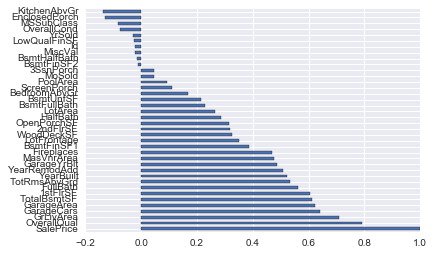

In [3]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train_df.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)
corr.SalePrice.plot(kind = "barh")
#corr.hist()
#sns.heatmap(corr)

# Target

In [4]:
y_ = train_df.SalePrice

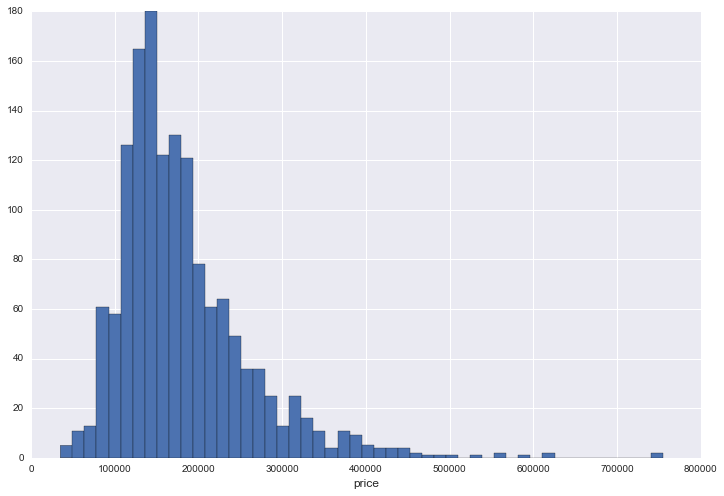

In [5]:
# Hist
plt.figure(figsize=(12,8))
#sns.distplot(train_df.price.values, bins=50, kde=False)
y_.hist(bins=50)
plt.xlabel('price', fontsize=12)
plt.show()

Note how the price is skewed. 

In [6]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
print(skew(y_)) # >0.5


1.880940746034036


In [7]:
y_ = train_df.SalePrice
y = y_log = np.log1p(y_)
train_df = train_df.drop('SalePrice', axis=1)
train_idx = len(train_df)

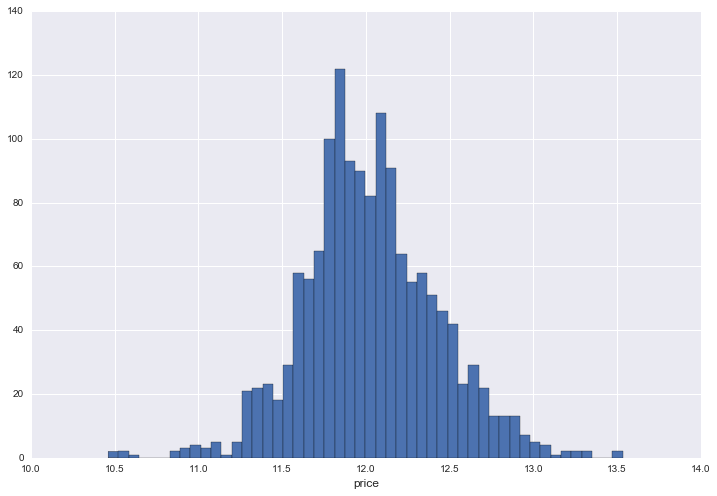

In [8]:
# Hist log(price)
import numpy as np
plt.figure(figsize=(12,8))
# log(price + 1) to avoid 0's
#sns.distplot(np.log(train_df.price + 1).values, bins=50, kde=False)
# Same as:
#sns.distplot(np.log(train_df['price'] + 1).values, bins=50, kde=False)
# Same as :
#np.log(train_df.price + 1).hist(bins=50)
# Same as:
y_log.hist(bins=50)
plt.xlabel('price', fontsize=12)
plt.show()

In [9]:
print(skew(y_log)) # <0.5

0.12122191311528363


## Test

In [10]:
test_df = pd.read_csv('../dat/test.csv')
print(test_df.shape)
len(test_df.columns) == len(train_df.columns)

(1459, 80)


True

## Merge/Concat

In [11]:
df = pd.concat([train_df, test_df], axis=0)
df.shape

(2919, 80)

# Handle missing vals

In [12]:
# Number of colomns with nulls
def check_nulls(df):
    print(df.isnull().sum())
    return len(df.isnull().sum().nonzero()[0])

In [13]:
print(check_nulls(df))

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu      1420
GarageType        157
GarageYrBlt       159
GarageFinish      159
GarageCars          1
GarageArea          1
GarageQual        159
GarageCond

## Special colomns handling

In [14]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
df.loc[:, "Alley"] = df.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
df.loc[:, "BedroomAbvGr"] = df.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
df.loc[:, "BsmtQual"] = df.loc[:, "BsmtQual"].fillna("No")
df.loc[:, "BsmtCond"] = df.loc[:, "BsmtCond"].fillna("No")
df.loc[:, "BsmtExposure"] = df.loc[:, "BsmtExposure"].fillna("No")
df.loc[:, "BsmtFinType1"] = df.loc[:, "BsmtFinType1"].fillna("No")
df.loc[:, "BsmtFinType2"] = df.loc[:, "BsmtFinType2"].fillna("No")
df.loc[:, "BsmtFullBath"] = df.loc[:, "BsmtFullBath"].fillna(0)
df.loc[:, "BsmtHalfBath"] = df.loc[:, "BsmtHalfBath"].fillna(0)
df.loc[:, "BsmtUnfSF"] = df.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
df.loc[:, "CentralAir"] = df.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
df.loc[:, "Condition1"] = df.loc[:, "Condition1"].fillna("Norm")
df.loc[:, "Condition2"] = df.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
df.loc[:, "EnclosedPorch"] = df.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
df.loc[:, "ExterCond"] = df.loc[:, "ExterCond"].fillna("TA")
df.loc[:, "ExterQual"] = df.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
df.loc[:, "Fence"] = df.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
df.loc[:, "FireplaceQu"] = df.loc[:, "FireplaceQu"].fillna("No")
df.loc[:, "Fireplaces"] = df.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
df.loc[:, "Functional"] = df.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
df.loc[:, "GarageType"] = df.loc[:, "GarageType"].fillna("No")
df.loc[:, "GarageFinish"] = df.loc[:, "GarageFinish"].fillna("No")
df.loc[:, "GarageQual"] = df.loc[:, "GarageQual"].fillna("No")
df.loc[:, "GarageCond"] = df.loc[:, "GarageCond"].fillna("No")
df.loc[:, "GarageArea"] = df.loc[:, "GarageArea"].fillna(0)
df.loc[:, "GarageCars"] = df.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
df.loc[:, "HalfBath"] = df.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
df.loc[:, "HeatingQC"] = df.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
df.loc[:, "KitchenAbvGr"] = df.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
df.loc[:, "KitchenQual"] = df.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
df.loc[:, "LotFrontage"] = df.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
df.loc[:, "LotShape"] = df.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
df.loc[:, "MasVnrType"] = df.loc[:, "MasVnrType"].fillna("None")
df.loc[:, "MasVnrArea"] = df.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
df.loc[:, "MiscFeature"] = df.loc[:, "MiscFeature"].fillna("No")
df.loc[:, "MiscVal"] = df.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
df.loc[:, "OpenPorchSF"] = df.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
df.loc[:, "PavedDrive"] = df.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
df.loc[:, "PoolQC"] = df.loc[:, "PoolQC"].fillna("No")
df.loc[:, "PoolArea"] = df.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
df.loc[:, "SaleCondition"] = df.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
df.loc[:, "ScreenPorch"] = df.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
df.loc[:, "TotRmsAbvGrd"] = df.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
df.loc[:, "Utilities"] = df.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
df.loc[:, "WoodDeckSF"] = df.loc[:, "WoodDeckSF"].fillna(0)

# Some numerical features are actually really categories

In [15]:
# Some numerical features are actually really categories
df = df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

# Ordinal colomns

In [16]:
# Encode some categorical features as ordered numbers when there is information in the order
df = df.replace({"Alley" : {"Grvl" : 0, "Pave" : 1},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 0, "Fa" : 1, "TA": 2, "Gd": 3, "Ex" : 4},
                       "ExterQual" : {"Po" : 0, "Fa" : 1, "TA": 2, "Gd": 3, "Ex" : 4},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 0, "Sev" : 1, "Maj2" : 2, "Maj1" : 3, "Mod": 4, 
                                       "Min2" : 5, "Min1" : 6, "Typ" : 7},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "KitchenQual" : {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "LandSlope" : {"Sev" : 0, "Mod" : 1, "Gtl" : 2},
                       "LotShape" : {"IR3" : 0, "IR2" : 1, "IR1" : 2, "Reg" : 3},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 0, "Pave" : 1},
                       "Utilities" : {"ELO" : 0, "NoSeWa" : 1, "NoSewr" : 2, "AllPub" : 3}}
                     )

## Get categorial colomns

In [17]:
categorical_features = df.select_dtypes(include = ["object"]).columns
print("Categorical features : " + str(len(categorical_features)))
df_cat = df[categorical_features]
print(df_cat.shape)

Categorical features : 26
(2919, 26)


In [18]:
print(check_nulls(df_cat))

MSSubClass       0
MSZoning         4
Alley            0
LandContour      0
LotConfig        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      1
Exterior2nd      1
MasVnrType       0
Foundation       0
Heating          0
CentralAir       0
Electrical       1
GarageType       0
GarageFinish     0
Fence            0
MiscFeature      0
MoSold           0
SaleType         1
SaleCondition    0
dtype: int64
5


## Fill catgorial Nulls as "None"

In [19]:
df_cat = df_cat.fillna("None")
print(check_nulls(df_cat))

MSSubClass       0
MSZoning         0
Alley            0
LandContour      0
LotConfig        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
Foundation       0
Heating          0
CentralAir       0
Electrical       0
GarageType       0
GarageFinish     0
Fence            0
MiscFeature      0
MoSold           0
SaleType         0
SaleCondition    0
dtype: int64
0


## Get numerical colomns

In [20]:
numerical_features = df.select_dtypes(exclude = ["object"]).columns
print("Numerical features : " + str(len(numerical_features)))
df_num = df[numerical_features]


Numerical features : 54


In [21]:
check_nulls(df_num)

Id                 0
LotFrontage        0
LotArea            0
Street             0
LotShape           0
Utilities          0
LandSlope          0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         0
ExterQual          0
ExterCond          0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         1
BsmtFinType2       0
BsmtFinSF2         1
BsmtUnfSF          0
TotalBsmtSF        1
HeatingQC          0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Functional         0
Fireplaces         0
FireplaceQu        0
GarageYrBlt      159
GarageCars         0
GarageArea         0
GarageQual         0
GarageCond         0
PavedDrive         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch

4

### Fillna of the remaining numerical colomns as median

In [22]:
df_num = df_num.fillna(df_num.median())

### Handle skewed numberical cols as log

In [23]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = df_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
df_num[skewed_features] = np.log1p(df_num[skewed_features])

41 skewed numerical features to log transform


# Categorial encoding as OHE

In [24]:
print(df.shape)
df_cat = pd.get_dummies(df_cat)
print(df_cat.shape)# Extra colmns due to extra encoding 1-col per category


(2919, 80)
(2919, 209)


## Merge numerical and categorial colomns again

In [25]:
df = pd.concat([df_num, df_cat], axis = 1)
df.shape

(2919, 263)

## Re-split train and test data

In [26]:
X = train_df = df[:train_idx]
X_test = test_df = df[train_idx:]
print(train_df.shape)
print(test_df.shape)

(1460, 263)
(1459, 263)


## Train/Val split

In [27]:
X_train, X_val, Y_train, Y_val = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)
print(X.shape)
print(y.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(1460, 263)
(1460,)
(1095, 263)
(1095,)
(365, 263)
(365,)


# Model XGB

In [28]:


model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
# Add silent=True to avoid printing out updates with each cycle
model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], verbose=True, early_stopping_rounds=5)
model_xgb = model

[0]	validation_0-rmse:10.9649
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:10.4185
[2]	validation_0-rmse:9.8994
[3]	validation_0-rmse:9.4063
[4]	validation_0-rmse:8.93788
[5]	validation_0-rmse:8.49291
[6]	validation_0-rmse:8.06925
[7]	validation_0-rmse:7.66676
[8]	validation_0-rmse:7.28439
[9]	validation_0-rmse:6.92113
[10]	validation_0-rmse:6.57705
[11]	validation_0-rmse:6.25009
[12]	validation_0-rmse:5.93857
[13]	validation_0-rmse:5.64223
[14]	validation_0-rmse:5.3619
[15]	validation_0-rmse:5.09544
[16]	validation_0-rmse:4.84165
[17]	validation_0-rmse:4.60139
[18]	validation_0-rmse:4.37319
[19]	validation_0-rmse:4.15618
[20]	validation_0-rmse:3.95039
[21]	validation_0-rmse:3.75478
[22]	validation_0-rmse:3.56887
[23]	validation_0-rmse:3.39209
[24]	validation_0-rmse:3.22381
[25]	validation_0-rmse:3.06383
[26]	validation_0-rmse:2.91283
[27]	validation_0-rmse:2.76867
[28]	validation_0-rmse:2.63207
[29]	validation_0-rmse:2.50264
[30]	validation_0-r

# Model LR

In [29]:

model = LinearRegression()
model.fit(X_train, Y_train)
model_lr = model

# Model Ridge

In [30]:

model = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
model.fit(X_train, Y_train)
model_ridge = model

# Model Lasso (Best 0.12)

In [31]:

model = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], max_iter = 50000, cv = 10)
model.fit(X_train, Y_train)
model_lasso = model

# Model ElasticNet (Same as Lasso)

In [32]:

model = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], max_iter = 50000, cv = 10)
model.fit(X_train, Y_train)
model_eNet = model

In [33]:
class AggregateModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, ratios=[]):
        self.models_ = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for m in self.models_:
            m.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            m.predict(X) for m in self.models_
        ])
        #return np.mean(predictions, axis=1)
        #print(predictions.shape)
        #print(self.ratios)
        #print(predictions)
        #return np.matrix(predictions) * np.transpose(np.matrix(self.ratios))
        return np.sum(predictions*self.ratios, axis=1)
    
    def validate(self, X, y):
        # make predictions
        predictions = self.predict(X)
        #print(predictions)
        #print(predictions.shape)
        #print(y.shape)
        return np.sqrt(mean_squared_error(predictions, y))

    
    def get_valid_weights(self, r, l):
        self.valid_ratios = []
        self.get_valid_weights_(0, r, l-1, [])


    def get_valid_weights_(self, curr_depth, r, l, c):
        if curr_depth == l:
            if sum(c) <= 1:
                c.append(1-sum(c))
                #print(c)
                self.valid_ratios.append(c.copy())# very important, otherwise, a pointer to c is appended which changes by the stack operation
                c.pop()
                #print(self.valid_ratios)
            return
        else:
            #print(a[curr_idx])
            #c.append(a[curr_idx])
            for child_idx in range(len(r)):
                c.append(r[child_idx])
                self.get_valid_weights_(curr_depth+1, r, l, c)
                c.pop()
            #curr_depth += 1
    
    def get_best_ratios(self, X_val, y_val):
        res = 0.1
        l = 10
        r = np.multiply(range(l+1), res)
        #print(r)
        #print(len(self.models))
        self.get_valid_weights(r, len(self.models_))        
        #print(self.valid_ratios)
        best_rmse = 10000
        for ratios in self.valid_ratios:
            #self.ratios = np.array(ratios)
            self.ratios = ratios
            #print(self.ratios.shape)
            #print(self.ratios)
            rmse = self.validate(X_val, y_val)
            #print(rmse)
            if rmse < best_rmse:
                best_rmse = rmse
                best_ratios = ratios
        self.ratios = best_ratios
        return best_ratios, best_rmse

# Evaluate

In [34]:
# make predictions
model = model_xgb
predictions = model.predict(X_val)


print("Mean Absolute Error : " + str(mean_absolute_error(predictions, Y_val)))
print("Mean Squared Error : " + str(mean_squared_error(predictions, Y_val)))
print("Root Mean Squared Error : " + str(np.sqrt(mean_squared_error(predictions, Y_val))))

Mean Absolute Error : 0.0880410644086
Mean Squared Error : 0.0169822583828
Root Mean Squared Error : 0.130315994348


# Visualize

In [35]:
predictions_train = model.predict(X)

print("Mean Absolute Error : " + str(mean_absolute_error(predictions_train, y.as_matrix())))
print("Mean Squared Error : " + str(mean_squared_error(predictions_train, y.as_matrix())))
print("Root Mean Squared Error : " + str(np.sqrt(mean_squared_error(predictions_train, y.as_matrix()))))


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262'] ['Id', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'YrSold', 'MSSubClass_SC120', 'MSSubClass_SC150', 'MSSubClass_SC160', 'MSSubClass_SC180', 'MSSubClass_SC190', 'MSSubClass_SC20', 'MSSubClass_SC30', 'MSSubClass_SC40', 'MSSubClass_SC45', 'MSSubClass_SC50', 'MSSubClass_SC60', 'MSSubClass_SC70', 'MSSubClass_SC75', 'MSSubClass_SC80', 'MSSubClass_SC85', 'MSSubClass_SC90', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_None', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Alley_0', 'Alley_1', 'Alley_None', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_ClyTile', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_None', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_None', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'CentralAir_N', 'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_None', 'Electrical_SBrkr', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_No', 'GarageFinish_Fin', 'GarageFinish_No', 'GarageFinish_RFn', 'GarageFinish_Unf', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_No', 'MiscFeature_Gar2', 'MiscFeature_No', 'MiscFeature_Othr', 'MiscFeature_Shed', 'MiscFeature_TenC', 'MoSold_Apr', 'MoSold_Aug', 'MoSold_Dec', 'MoSold_Feb', 'MoSold_Jan', 'MoSold_Jul', 'MoSold_Jun', 'MoSold_Mar', 'MoSold_May', 'MoSold_Nov', 'MoSold_Oct', 'MoSold_Sep', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_None', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial']
expected f27, f199, f125, f5, f13, f130, f148, f195, f53, f169, f34, f41, f256, f243, f182, f159, f67, f139, f149, f12, f104, f108, f183, f196, f231, f226, f193, f37, f204, f215, f86, f224, f162, f79, f52, f145, f134, f240, f198, f252, f174, f8, f150, f98, f185, f203, f258, f78, f87, f190, f102, f248, f126, f111, f110, f129, f15, f135, f61, f6, f222, f103, f43, f46, f140, f44, f154, f250, f216, f155, f176, f144, f18, f189, f75, f214, f2, f261, f39, f10, f59, f82, f42, f180, f28, f24, f227, f257, f62, f157, f239, f158, f83, f0, f131, f233, f147, f230, f69, f202, f114, f235, f47, f48, f66, f133, f167, f40, f113, f136, f35, f220, f4, f7, f178, f200, f218, f156, f238, f251, f117, f16, f73, f76, f33, f173, f116, f3, f118, f225, f236, f96, f56, f81, f89, f172, f208, f171, f127, f212, f64, f23, f25, f228, f223, f65, f253, f221, f45, f186, f51, f60, f93, f184, f50, f207, f194, f259, f229, f11, f247, f164, f201, f115, f191, f132, f187, f20, f91, f63, f88, f161, f255, f30, f166, f188, f55, f192, f70, f99, f209, f153, f57, f71, f112, f128, f206, f254, f19, f109, f31, f85, f9, f181, f177, f124, f160, f77, f26, f122, f1, f21, f168, f137, f101, f72, f84, f151, f179, f210, f165, f262, f120, f246, f146, f14, f234, f95, f170, f107, f38, f105, f106, f138, f92, f119, f141, f29, f36, f68, f97, f163, f211, f232, f242, f244, f22, f90, f94, f245, f32, f175, f142, f121, f205, f58, f54, f241, f17, f100, f123, f260, f143, f80, f213, f152, f74, f217, f237, f219, f197, f249, f49 in input data
training data did not have the following fields: GarageType_Basment, Heating_Floor, MSSubClass_SC75, OpenPorchSF, BldgType_Duplex, LandContour_Bnk, BldgType_1Fam, RoofStyle_Gable, Fireplaces, FireplaceQu, Exterior2nd_Wd Sdng, Condition1_PosN, RoofMatl_Tar&Grv, MSSubClass_SC40, HouseStyle_1.5Unf, Fence_MnWw, SaleCondition_Normal, HouseStyle_2.5Fin, Foundation_Stone, MoSold_May, MSZoning_RL, RoofMatl_Metal, PoolQC, MoSold_Dec, Electrical_FuseF, GarageFinish_Fin, Exterior2nd_Brk Cmn, MSSubClass_SC80, HouseStyle_1.5Fin, Condition2_Norm, ExterCond, Neighborhood_SWISU, MasVnrType_None, MiscFeature_Gar2, BsmtFullBath, Neighborhood_OldTown, Condition2_RRAn, Neighborhood_NPkVill, Electrical_FuseA, Neighborhood_NridgHt, Foundation_Wood, MoSold_Sep, MSSubClass_SC45, Exterior2nd_HdBoard, BsmtFinSF1, GarageCond, LotConfig_Corner, PoolArea, BldgType_Twnhs, MSSubClass_SC85, Exterior1st_AsphShn, Heating_Grav, MSSubClass_SC20, Fence_GdWo, Exterior1st_WdShing, YrSold, Foundation_PConc, YearRemodAdd, Exterior2nd_None, RoofStyle_Shed, CentralAir_N, Foundation_CBlock, GarageType_Detchd, Neighborhood_ClearCr, LandSlope, MoSold_Aug, MoSold_Mar, SaleType_ConLw, MSZoning_FV, Fence_GdPrv, Exterior2nd_Plywood, SaleType_ConLI, SaleType_Oth, Neighborhood_Somerst, HeatingQC, Exterior1st_ImStucc, MiscFeature_Shed, SaleCondition_Family, Electrical_SBrkr, Neighborhood_NWAmes, Exterior1st_BrkFace, ScreenPorch, RoofStyle_Gambrel, LotArea, BsmtFinType1, FullBath, RoofStyle_Flat, Heating_OthW, BsmtQual, LandContour_Lvl, Id, RoofStyle_Mansard, RoofMatl_WdShngl, LandContour_Low, BedroomAbvGr, MasVnrType_Stone, GarageType_2Types, ExterQual, Condition2_RRNn, GarageFinish_Unf, Exterior2nd_VinylSd, Functional, Neighborhood_Crawfor, RoofMatl_CompShg, CentralAir_Y, Exterior2nd_MetalSd, Neighborhood_NAmes, Condition1_Artery, YearBuilt, HalfBath, MSSubClass_SC150, Neighborhood_IDOTRR, HouseStyle_1Story, MoSold_Apr, SaleCondition_Abnorml, BsmtCond, Neighborhood_Edwards, Neighborhood_Gilbert, GarageType_No, RoofStyle_Hip, Exterior1st_CemntBd, SaleType_COD, Alley_1, Exterior2nd_BrkFace, Exterior1st_AsbShng, GarageType_CarPort, GarageFinish_RFn, Neighborhood_BrkSide, Electrical_Mix, MSSubClass_SC60, Exterior1st_HdBoard, Fence_No, MSSubClass_SC180, Neighborhood_Mitchel, BsmtFinType2, LotConfig_CulDSac, PavedDrive, Exterior1st_Stucco, Exterior2nd_AsphShn, MasVnrType_BrkCmn, Neighborhood_MeadowV, MiscFeature_Othr, Alley_0, TotRmsAbvGrd, Condition2_Feedr, Condition2_PosN, MiscVal, Condition1_Norm, Condition2_Artery, MoSold_Jan, Condition1_RRAe, MSZoning_C (all), MSSubClass_SC30, OverallCond, HouseStyle_2.5Unf, SaleType_None, Heating_GasW, Foundation_Slab, MoSold_Oct, TotalBsmtSF, MSSubClass_SC70, Exterior2nd_CBlock, Exterior1st_Plywood, Alley_None, Exterior2nd_Stucco, HouseStyle_SFoyer, MSSubClass_SC190, SaleType_WD, MoSold_Jul, Exterior2nd_Other, MSZoning_None, Neighborhood_Blueste, GarageArea, Neighborhood_StoneBr, Exterior1st_MetalSd, GarageYrBlt, SaleCondition_Alloca, GarageQual, BsmtFinSF2, SaleType_CWD, Street, LotConfig_FR3, MoSold_Feb, HouseStyle_SLvl, Exterior2nd_Wd Shng, SaleCondition_Partial, RoofMatl_ClyTile, MSSubClass_SC160, GarageType_Attchd, WoodDeckSF, EnclosedPorch, Neighborhood_Blmngtn, Exterior2nd_Stone, Electrical_FuseP, Neighborhood_Veenker, Condition1_RRNe, Condition1_RRNn, MSSubClass_SC120, LotFrontage, Condition1_Feedr, LotShape, MasVnrArea, RoofMatl_Roll, 1stFlrSF, Exterior1st_BrkComm, Foundation_BrkTil, 2ndFlrSF, MSZoning_RH, MSZoning_RM, GarageCars, Condition1_PosA, SaleType_New, BsmtUnfSF, Condition2_PosA, Electrical_None, Neighborhood_BrDale, SaleCondition_AdjLand, HouseStyle_2Story, Exterior1st_VinylSd, RoofMatl_WdShake, MSSubClass_SC90, LandContour_HLS, BsmtExposure, OverallQual, Neighborhood_NoRidge, Condition2_RRAe, 3SsnPorch, Exterior1st_None, Exterior2nd_CmentBd, MSSubClass_SC50, GarageFinish_No, LotConfig_FR2, Fence_MnPrv, LotConfig_Inside, BldgType_2fmCon, Utilities, BsmtHalfBath, Exterior1st_Stone, GarageType_BuiltIn, MoSold_Jun, Neighborhood_Timber, SaleType_ConLD, Neighborhood_CollgCr, Neighborhood_Sawyer, Exterior2nd_ImStucc, Exterior1st_CBlock, KitchenQual, Condition1_RRAn, Exterior2nd_AsbShng, GrLivArea, BldgType_TwnhsE, MoSold_Nov, KitchenAbvGr, Exterior1st_Wd Sdng, MasVnrType_BrkFace, Neighborhood_SawyerW, Heating_GasA, MiscFeature_TenC, RoofMatl_Membran, MiscFeature_No, LowQualFinSF, SaleType_Con, Heating_Wall

In [ ]:
predictions_train.shape

In [ ]:
def hist_plot(logp):
    plt.figure(figsize=(12,8))
    logp.hist(bins=50)
    #logp.plot.line()
    plt.xlabel('price', fontsize=12)
    plt.show()

In [ ]:
def line_plot(logp):
    plt.figure(figsize=(12,8))
    #logp.hist(bins=50)
    logp.plot.line()
    plt.xlabel('price', fontsize=12)
    plt.show()

In [ ]:
hist_plot(pd.DataFrame(predictions_train))
type(pd.DataFrame(predictions_train))

In [ ]:
hist_plot(y_log)

In [ ]:
abs_logerr = abs(y_log-predictions_train)

In [ ]:
hist_plot(abs_logerr)

In [ ]:
abs_err = abs(y_-np.expm1(predictions_train))
hist_plot(abs_err)# Some errors might reach 50K and 200K!!. A new metric is definetly needed.
# %Err metric doesnot work, as 50K out of 1M is 5%, but still a big err!
# We need abs amount error threshold

# Submit

In [36]:
# Model aggregation
#predictions = 0.5*model_lasso.predict(X_test) + 0.5*model_ridge.predict(X_test)
agg = AggregateModels(models=[model_lasso, model_ridge, model_eNet, model_xgb, model_lr])
#agg = AggregateModels(models=[model_lasso])
[best_r, best_rmse] = agg.get_best_ratios(X_val, Y_val)
print([best_r, best_rmse])
predictions = agg.predict(X_test.as_matrix())

[[0.0, 0.0, 0.70000000000000007, 0.30000000000000004, 0.0], 0.11687883868082959]


In [37]:
# make predictions
model = agg
predictions = model.predict(X_val)


print("Mean Absolute Error : " + str(mean_absolute_error(predictions, Y_val)))
print("Mean Squared Error : " + str(mean_squared_error(predictions, Y_val)))
print("Root Mean Squared Error : " + str(np.sqrt(mean_squared_error(predictions, Y_val))))

Mean Absolute Error : 0.0794054086494
Mean Squared Error : 0.0136606629314
Root Mean Squared Error : 0.116878838681


In [ ]:
#predictions = model.predict(X_test.as_matrix())

In [ ]:
predicted_prices = np.expm1(predictions)

In [ ]:
predicted_prices

In [ ]:
my_submission = pd.DataFrame({'Id': test_df.Id, 'SalePrice': predicted_prices})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)


